# Computational Methods in Economics (winter term 2019/20)

## Problem Set 6

#### DEADLINE: Wednesday, February 5, 12 pm (Noon)

### Preliminaries

#### Import Modules

In [1]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline

import funapprox_cme as fa

## Question 1

In this question, we use Gaussian-Legendre quadrature to approximate the mean of the *beta distribution* (https://en.wikipedia.org/wiki/Beta_distribution). First, compute the analytical mean for parameter values **a = 3** and **b = 5** (in the Wikipedia article, the parameters are called $\alpha$ and $\beta$, respectively), either by hand or using a **Scipy** package (**Hint**: check the contents of **scipy.stats**). Store your result in a scalar variable named **mean_true**. 
 
Next, use Gauss-Legendre to compute the numerical approximation **mean_approx**. For the pdf, you can again make use of the appropriate **Scipy** package. Note that the pdf of the beta distribution is defined in the range $[0, 1]$.

NB: Be careful not to mix up the parameters **a** and **b** of the beta distribution with our notation for the end points of the distribution's interval (here $[0, 1]$).

In [2]:
### BEGIN SOLUTION

from scipy.stats import beta

## Parameters of the beta distribution
a = 3
b = 5

mean_true = beta.stats(a, b, loc=0, scale=1, moments='m')

# approximate mean
[nodes_l, weights_l] = np.polynomial.legendre.leggauss(22)
X = beta.pdf( (nodes_l + 1) * 0.5 , a, b) * (nodes_l + 1) * 0.5
mean_approx = 0.5 * weights_l @ X

### END SOLUTION

In [3]:
# THIS IS A TEST CELL!
### BEGIN HIDDEN TESTS
assert mean_true == 0.375
### END HIDDEN TESTS

In [4]:
# THIS IS A TEST CELL!
### BEGIN HIDDEN TESTS
assert np.allclose( mean_approx, 0.375)
assert mean_approx != 0.375
### END HIDDEN TESTS

## Question 2

In the stochastic NGM, let output be given by $y_t = z_t f(k_t)$. $z_t$ is a random variable ("shock") whose *logarithm* follows an AR(1) process: 

\begin{equation}
    \ln(z_{t+1}) = \rho \ln(z_t) + \epsilon_{t+1},\ \ \epsilon_{t+1} \sim N(0, \sigma^2)
\end{equation}

Moreover, in this version of the growth model, let $\delta = 1$ (full depreciation). The production function (without the shock) is given by


$$
    f(k) = k^\alpha
$$

(and hence labor supply is implicitly set constant to 1).


The random variable $\epsilon_{t+1}$ enters the Euler equation on the right hand side, and hence there is an expected value:

\begin{equation}
\begin{split}
    c_t^{-1} &= \beta E[c_{t+1}^{-\nu} z_{t+1} f_k(k_{t+1})] \\
               &= \beta E[c_{t+1}^{-\nu} \exp(\rho \ln(z_t) + \epsilon_{t+1}) \alpha k_{t+1}^{\alpha -1}] \\
               &= \beta E[c_{t+1}^{-\nu}  z_t^\rho \exp(\epsilon_{t+1}) \alpha k_{t+1}^{\alpha -1} ]
\end{split}    
\end{equation}

If $\epsilon_{t+1}$ is normally distributed with mean $\mu$ and variance $\sigma^2$, the expectation of $g(\epsilon_{t+1})$ (for an arbitrary function $g$) can be approximated by

\begin{equation}
    E[g(\epsilon_{t+1})] = \sum^n_{i = 1} \frac{1}{\sqrt{\pi}} \omega_i g(\sqrt{2} \sigma \xi_i + \mu)
\end{equation}

Hence, the right hand side of the Euler equation can be approximated in the following way:

\begin{equation}
\begin{split}
   c_t^{-1}  &= \beta E[c_{t+1}^{-\nu}  z_t^\rho \exp(\epsilon_{t+1}) \alpha k_{t+1}^{\alpha -1} ] \\
                  &= \beta \sum^n_{i = 1} \frac{1}{\sqrt{\pi}} \omega_i c_{t+1}^{-1}  z_t^\rho \exp(\sqrt{2} \sigma \xi_i) \alpha k_{t+1}^{\alpha -1}  
\end{split}
\end{equation}

Note that we could use this equation to solve the model using root finding and function approximation tools. Here, we will just employ this equation to show that a stochastic NGM cannot attain a steady state. 

If there were a steady state, we would have $c_t = c_{t+1}$. Hence,

\begin{equation}
   1 = \beta \sum^n_{i = 1} \frac{1}{\sqrt{\pi}} \omega_i  z_t^\rho   \exp(\sqrt{2} \sigma \xi_i) \alpha k_{t+1}^{\alpha -1}
\end{equation}

and rearranging terms gives

\begin{equation}
   k_{t+1} = \big[ \alpha\beta z_t^\rho \sum^n_{i = 1} \frac{1}{\sqrt{\pi}} \omega_i    \exp(\sqrt{2} \sigma \xi_i) \big]^{\frac{1}{1-\alpha}} \tag{1}
\end{equation}



(a) Evaluate the sum on the RHS of (1), i.e.

$$
    \sum^n_{i = 1} \frac{1}{\sqrt{\pi}} \omega_i    \exp(\sqrt{2} \sigma \xi_i) 
$$    

using Gaussian-Hermite nodes and weights, with $n = 8$ and $\sigma = 0.0067$. Store the result in a scalar named **sum_ee**.


In [5]:
### BEGIN SOLUTION
sigma = 0.0067
n = 8
[nodes, weights] = np.polynomial.hermite.hermgauss(n)
sum_ee = np.pi**(-0.5) * np.exp(np.sqrt(2) * sigma * nodes) @ weights
### END SOLUTION

In [6]:
assert np.allclose(sum_ee, 1.00002)

(b) The function **ar1** below implements an AR1 process of length T. Use it to create a T-by-1 array **z** in which each element $z_t$ comes from the AR1 process above,

\begin{equation}
    \ln(z_{t+1}) = \rho \ln(z_t) + \epsilon_{t+1},\ \ \epsilon_{t+1} \sim N(0, \sigma^2)
\end{equation}

for $T = 100$, $\rho = 0.8$ and $\sigma = 0.0067$. You do not need to change the default settings in **ar1**.


In [7]:
def ar1(T, rho, sigma, wbar = 0):
    '''
    Implements an AR1 process of length T with autocorrelation rho and standard deviation sigma
    '''
    w = np.zeros(T)
    ## initialize at wbar
    w[0] = wbar
    
    for t in range(1,T):        
        w[t] = (1 - rho) * wbar + rho * w[t-1] + sigma * np.random.normal()
        
    return w

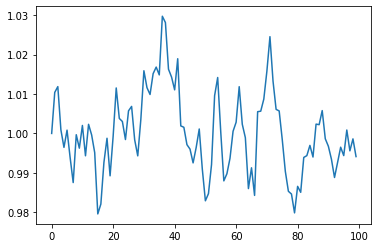

In [8]:
### BEGIN SOLUTION
T = 100
rho = 0.8
sigma = 0.0067
z = np.exp( ar1(100, rho, sigma) )
plt.plot(z)
### END SOLUTION

In [9]:
assert np.allclose(z.mean(), 1, atol = 1e-2)

(c) With the results and parameter values from (a) and (b), use equation (1) to simulate the time paths for output and consumption. That is, return two T-by-1 arrays **Y** and **C** for output and consumption, respectively, where the $t$-th element contains the correspoding variable value in period $t$. For initial output, set $y_0 = 0.7$. Moreover, let $\alpha = 0.33$, $\beta = 0.96$ and $T = 100$.

**Hint**: For every period $t$, we have $c_t = y_t - k_{t+1}$ and $y_{t+1} = z_{t+1} k_{t+1}^\alpha$.

*Optional question (no submission required)*: Why do the resulting time paths imply that there is no steady state?

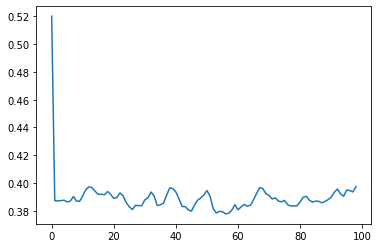

In [10]:
### BEGIN SOLUTION
alpha = 0.33
beta = 0.96
T = 100
rho = 0.8
sigma = 0.0067

z = np.exp( ar1(T+1, rho, sigma) )

C = np.zeros(T)
Y = 0.7 * np.ones(T+1)
for time in range(T):
    kp = (alpha * beta * z[time]**rho * sum_ee)**(1/(1-alpha))
    C[time] = Y[time] - kp
    Y[time + 1] = z[time + 1] * kp**alpha
    
plt.plot(C[:-1])   
### END SOLUTION

In [11]:
assert np.allclose(C.std(), 0.014, atol = 1e-2)

## Question 3 (N)

*This was the exam question 2019*.

Consider a growth model without capital. Instead, output is produced using labor and energy. Energy comes in two forms, a "dirty" and a "clean" variant. Using dirty energy $e_t$ causes emissions of a pollutant and hence a *pollution externality*: it contributes to a stock of the pollutant which negatively affects production. Apart from this negative productivity effect, there is no other cost of dirty energy use. In contrast, clean energy $r_t$ does not cause pollution, but has a constant marginal cost $\rho$, paid in output units. 

Formally, per-period utility is given by:

\begin{equation}
    u(c_t, h_t) = \frac{c_t^{1-\nu}}{1-\nu} - B \frac{h_t^{1+\eta}}{1+\eta}
\end{equation}

Output is given by

\begin{equation}
    y_t = D(s_t) f(e_{t}, r_t, h_t) = D(s_t) A e_t^\alpha r_t^\gamma h_{t}^{1-\alpha - \gamma}
\end{equation}

where $s_t$ denotes the pollution stock. $D(s_t)$ is called a damage function: it reduces available output, to an extent which depends on the size of the pollution stock. We assume the following functional form:

\begin{equation}
    D(s_{t}) = \exp(- s_t)
\end{equation}

$s_t$ evolves according to the following law of motion:

\begin{equation}
    s_{t + 1} = \phi s_t + e_t
\end{equation}

In other words, a share $(1 - \phi)$ of the current pollution stock depreciates every period. The remaining share, together with the current dirty energy use/emissions $e_t$, makes up the pollution stock in the subsequent period.

The planner's problem reads

\begin{equation}
    \max_{\left\{c_t, h_t, e_t, r_t, s_{t+1}\right\}} \sum^\infty_{t = 0} \beta^t \left[\frac{c_t^{1-\nu}}{1-\nu} - B \frac{h_t^{1+\eta}}{1+\eta} \right]
\end{equation}

s.t. the resource constraint and the law of motion for $s_t$:

\begin{equation}
    c_t = \exp(-s_t) A e_t^\alpha r_t^\gamma h_{t}^{1-\alpha - \gamma} - \rho r_t
\end{equation}
\begin{equation}
    s_{t + 1} = \phi s_t + e_t
\end{equation}

(As a side note, this model is not well-suited for representing climate change, but rather a more short-term production externality, e.g. air pollution.)

(a) Using the parameter values below, compute the steady state of the model. Report the steady state values $(e_s, r_s, h_s)$ (in this order!) in a Numpy array named **x_s**.

*Hint*: For comparison, you get the following steady state value for $e_s$:

\begin{equation}
    e_s = 0.1528
\end{equation}


In [12]:
## utility
beta = 0.9      # discount factor
nu = 2          # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply
B = 1

## production
alpha = 0.25
gamma = 0.05
A = 1

rho = 0.1       # marginal cost of clean energy
phi = 0.5       # share of pollutant that remains in the air between two periods

## initial values
s0 = 0.05

params = {'beta': beta, 'nu': nu, 'eta': eta, 'alpha': alpha, 'gamma': gamma,
          'phi': phi, 'rho': rho, 'A': A, 'B': B }

In [13]:
### BEGIN SOLUTION

## functions
def u(c, h, pm):
    """
    Evaluates an additive-separable utility function with consumption and labor as arguments
    """
    return c**(1 - pm['nu'])/(1 - pm['nu']) - pm['B'] * h**(1 + pm['eta'])/(1 + pm['eta'])

def f(e, r, h, pm):
    """
    Evaluates a Cobb-Douglas production function with coefficient alpha and shift parameter A, for two inputs k and h
    """
    return pm['A'] * e**pm['alpha'] * r**pm['gamma'] * h**(1 - pm['alpha'] - pm['gamma'])


def f_diff(e, r, h, pm):
    """
    Evaluates the first derivatives (returned as a tuple) of the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs k and h
    """
    return np.array( (pm['alpha'] * f(e, r, h, pm)  / e, 
                      pm['gamma'] * f(e, r, h, pm)  / r, 
                     (1 - pm['alpha'] - pm['gamma'] ) * f(e, r, h, pm) / h) )

## steady-state conditions
def steady(x, pm):
    """
    Returns the vector-valued function consisting of the steady-state conditions 
    """
    y = np.zeros(3)
    
    e, r, h = x
    s = e / (1 - pm['phi'])

    c = np.exp(-s) * f(e, r, h, pm) - pm['rho'] * r
    mp = np.exp(-s) * f_diff(e, r, h, pm)
    
    y[0] = pm['alpha'] * e**(-1) - pm['beta'] * (pm['alpha'] * pm['phi'] * e**(-1) + 1) 
    y[1] = mp[1] - rho
    y[2] = c**(- pm['nu']) * mp[2] - B * h**pm['eta']
    
    return y

x0 = np.array([0.1, 0.2, 1.2])
res = scipy.optimize.root(steady, x0, args = ( params ), tol = 1e-8, method = "broyden1")

x_s = res.x 
## END SOLUTION

In [14]:
# THIS IS A TEST CELL!
### BEGIN HIDDEN TESTS
assert np.allclose( x_s, np.array([0.15277778, 0.25043399, 1.24441083]) )
### END HIDDEN TESTS

(b) Use dynamic programming to solve the model, given the initial pollution stock $s_0 = 0.05$. Your main result should be an array of coefficient, **a_ch**, of dimension 10-by-1. In other words, when approximating functions, use a degree of approximation $n = 9$. 

*Hint 1*: For value function iteration, you can use $V^{(0)}(s) = - s^2$ as initial guess. 

*Hint 2*: For comparison, the first element of your **a_ch** vector should be **a_ch[0]** = -28.6624417.


In [15]:
### BEGIN SOLUTION

#### Choose a grid around the steady state value for capital

m = 10
s_min = 0.05
s_max = 0.5

s_grid = fa.chebgrid(s_min, s_max, m)

#### Set the degree of approximation and an initial guess for the value function

n = m - 1

## initial guess for VF
V0 = - s_grid**2
## compute implied basis coefficients
a0 = fa.chebapprox(V0, n)

#### Define the objective function for the optimization step (= RHS of Bellman equation)

def vf_rhs(x, s, a, s_min, s_max, pm):
    """
    RHS of the Bellman equation
    """
    e = np.exp(x[0])
    r = np.exp(x[1])
    h = np.exp(x[2])
    
    sp = pm['phi'] * s + e
    
    return (- u( np.exp(- s) * f(e, r, h, pm) - pm['rho'] * r, h, pm) 
            - pm['beta'] * np.polynomial.chebyshev.chebval(fa.chebconvert(sp, s_min, s_max), a) )

#### Solve model with value function iteration

def opt_step(s_grid, x0, a_ch, s_min, s_max, pm):     
    """
    Function that loops over all states (= elements in k_grid) and solves the respective optimization problem (obj_fun, initial guess x0)
    for a given vector of Chebyshev basis coefficients a_ch
    -> uses Scipy's optimize module
    """
    ## initialize policy and value functions
    V = np.zeros(m)
    E = np.zeros(m)
    R = np.zeros(m)
    H = np.zeros(m)
    
    ## loop
    for (ind, s) in enumerate(s_grid):
    ## optimization step
        res = scipy.optimize.minimize(vf_rhs, x0, args = (s, a_ch, s_min, s_max, pm), method ='BFGS') 
        V[ind] = - res.fun
        E[ind], R[ind], H[ind]  = np.exp( res.x )
        if res.success is not True:
            print(res.message)
        
    return V, E, R, H

## initialize initial guess for basis coefficients and optimization
a_ch = a0.copy()
x0 = np.log(x_s)

eps = 1
it = 0
maxit = 200

while eps > 1e-8 and it < maxit:
    it += 1
    ## optimization step
    V, E, R, H = opt_step(s_grid, x0, a_ch, s_min, s_max, params)
    ## fitting step
    a_new = fa.chebapprox(V, n)
    ## compute convergence criterion
    eps = np.linalg.norm(a_new - a_ch)
    ## update coefficients
    a_ch = a_new.copy()
    
#     if it % 10 == 0:
#         print(it, eps)
# print(it, eps)

### END SOLUTION


In [16]:
# THIS IS A TEST CELL!
### BEGIN HIDDEN TESTS
assert np.allclose( a_ch, np.array([-2.86624417e+01, -8.92831204e-01, -2.54647106e-02, -5.90130821e-04,
       -1.10725420e-05, -1.72754295e-07, -2.37927958e-09, -1.15005095e-10,
        4.46966515e-11,  1.49788176e-10]) )
### END HIDDEN TESTS

(c) Derive approximations to the policy functions (i.e. compute approximation coefficients **a_e**, **a_r** and **a_h**) and simulate the economy for $T = 30$. Plot the time paths for $e$, $r$ and $h$ (named **et**, **rt** and **ht**, respectively), and include their corresponding steady state values.

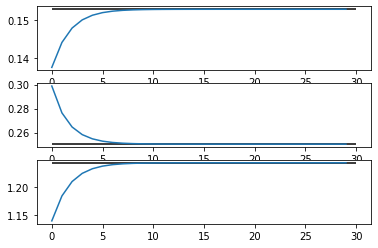

In [17]:
### BEGIN SOLUTION

a_e = fa.chebapprox(E, n)
a_r = fa.chebapprox(R, n)
a_h = fa.chebapprox(H, n)

## number of periods
T = 30

## initialize arrays to keep track of time series
st = np.zeros(T+1)
et = np.zeros(T)
rt = np.zeros(T)
ht = np.zeros(T)

## initial capital stock is given
st[0] = s0

## loop over time and use policy function approximations to fill kt and ht
for t in range(T):
    et[t] = np.polynomial.chebyshev.chebval( fa.chebconvert(st[t], s_min, s_max), a_e)
    rt[t] = np.polynomial.chebyshev.chebval( fa.chebconvert(st[t], s_min, s_max), a_r )
    ht[t] = np.polynomial.chebyshev.chebval( fa.chebconvert(st[t], s_min, s_max), a_h )
    st[t + 1] = params['phi'] * st[t] + et[t]
    
## plot optimal plans and check for convergence to steady state
fig, ax = plt.subplots(3,1)
ax[0].plot(range(T), et)
ax[0].hlines(x_s[0], 0, T)
ax[1].plot(range(T), rt)
ax[1].hlines(x_s[1], 0, T)   
ax[2].plot(range(T), ht)
ax[2].hlines(x_s[2], 0, T) 

### END SOLUTION

In [18]:
assert np.allclose(a_e, np.array([ 1.51164831e-01,  1.37937099e-02,  2.69269608e-04,  2.22815220e-06,
       -1.25248601e-07,  2.56957335e-07,  2.83333412e-07, -1.75284347e-07,
       -1.92270845e-07, -3.10513586e-08]))

In [19]:
assert np.allclose(et.mean(), 0.15161157605)

-------------------------------------------------------------------------------------------------------------------------------